# Source models for Nath & Thingbaijam (2012)

Read the source description input files from the online supplementary material and write them to XML.

In [1]:
%matplotlib inline
%load_ext autoreload

In [2]:
import os

%autoreload 2
import source_model_tools as smt

import numpy as np
import pandas as pd
import toolbox as tb
import lxml.etree as et
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from StringIO import StringIO
from IPython.display import display

import hmtk.sources as src
from openquake.hazardlib import tom, geo

from hmtk.plotting.mapping import HMTKBaseMap
from hmtk.parsers.source_model.nrml04_parser import nrmlSourceModelParser

In [3]:
layer_ids = [1, 2, 3, 4]
layer_depths_km = [0, 25, 70, 180, 300]

df_layers = pd.DataFrame(zip(layer_ids, layer_depths_km[:-1], layer_depths_km[1:]), columns=['id','zmin','zmax'])
df_layers

,id,zmin,zmax
0,1,0,25
1,2,25,70
2,3,70,180
3,4,180,300


In [4]:
use_recomputed = True
# define some lists needed at different stages
min_mags = [4.5, 5.5]

# define the input file names from the original paper
model_path = '../Data/nath2012probabilistic'
if use_recomputed:
    smoothed_model_path = './Recomputed'
else:
    smoothed_model_path = model_path
polygon_file_template = os.path.join(model_path,'polygonlay%d.txt')
seismicity_file_template = os.path.join(model_path,'seismicitylay%d.txt')
polygon_files = [polygon_file_template % i for i in layer_ids] 
seismicity_files = [seismicity_file_template % i for i in layer_ids] 

smoothed_data_template = os.path.join(smoothed_model_path,'lay%dsmooth%.1f.txt')
smoothed_data_files = [[smoothed_data_template % (i, m) 
                        for i in layer_ids] for m in min_mags]

# implement some column-name replacements
variable_mapping = {'avalue': 'a', 'bvalue': 'b', 'stdbvalue': 'stdb'}

# an input file supplies some auxiliary data
aux_file = 'auxiliary data.csv'

# define prefixes for the output file names and models
areal_source_model_file = 'areal_source_model'
smoothed_source_data_file = 'smoothed_source_model'

In [5]:
def read_polygons(file_name):
    """
    Read polygon descriptions from text file into pandas.DataFrame. 
    
    File format as per Nath & Thingbaijam (2012).
    """
    with open(file_name) as f:
        keys = f.readline().strip().split(',')
        result = []
        for line in f.readlines():
            values = line.strip().split(',', len(keys) - 1)
            entry = {}
            for key, value in zip(keys, values):
                key = key.strip('[]')
                value = value.strip('[]').replace(';', '\n')
                if key == 'zoneid':
                    value = int(value)
                else:
                    value = np.genfromtxt(StringIO(value), delimiter=',')
                entry[key] = value
            result.append(entry)
    return pd.DataFrame.from_dict(result)

In [74]:
# read areal polygons and seismicity statistics for each layer
areal_df = pd.DataFrame()
areal_polygons_df = pd.DataFrame()
for i, layer in df_layers.iterrows():
        
    # read seismicity and polygons
    layer_seis_df = pd.read_csv(seismicity_files[i])
    layer_seis_df.rename(columns=variable_mapping, inplace=True)
    layer_poly_df = read_polygons(polygon_files[i])
    
    # fill in depths, specify source mechanisms, clean up dip & rake
    n_zones = len(layer_seis_df)
    idx = layer_seis_df.index
    layer_seis_df['zmin'] = pd.Series(np.full(n_zones, layer['zmin']), index=idx)
    layer_seis_df['zmax'] = pd.Series(np.full(n_zones, layer['zmax']), index=idx)
    layer_seis_df['layerid'] = pd.Series(np.full(n_zones, layer['id']), index=idx)
    layer_seis_df['rake'] = tb.wrap(layer_seis_df['rake'])
    layer_seis_df['mechanism'] = pd.Series(
        smt.focal_mechanisms(layer_seis_df['dip'], layer_seis_df['rake']), index=idx)
    layer_seis_df.loc[layer_seis_df['dip'] == -1, 'dip'] = 45
    layer_seis_df.loc[layer_seis_df['mechanism'] == 'undefined', 'rake'] = 90
    layer_seis_df.loc[layer_seis_df['strike'] == -1, 'strike'] = 0
    layer_seis_df['mmin'] = pd.Series(np.full(n_zones, min_mags[0]), index=idx) 
    
    # put it all together
    layer_source_df = pd.merge(layer_seis_df, layer_poly_df, on='zoneid')
    areal_df = pd.concat([areal_df, layer_source_df], ignore_index=True)
    areal_polygons_df = pd.concat([areal_polygons_df, layer_poly_df], ignore_index=True)

# merge auxiliary data (crucially, tectonic zones)
aux_df = pd.read_csv(aux_file)
aux_df = aux_df.drop(['zmin','zmax','dip','rake','mechanism'], axis=1)
areal_df = pd.merge(areal_df, aux_df, on='zoneid')
areal_df['polygon coordinates'] = areal_df['polygon coordinates'].astype(np.ndarray)

# convert polygons coordinates to objects
areal_df['polygon'] = [
    smt.MyPolygon([geo.point.Point(lat, lon)
                   for lat, lon in area_series['polygon coordinates']])
    for _, area_series in areal_df.iterrows()]

# convert zoneid to string - sort_and_reindex takes care of "human" sorting
areal_df['zoneid'] = [str(item) for item in areal_df['zoneid']]
areal_df = smt.sort_and_reindex(areal_df)

In [75]:
# show a summary including megathrust zones and bin statistics
drop_columns = ['tectonic zone', 'region', 'concerns', 'zmax', 'zmin',
                'polygon coordinates', 'polygon',
                'aspect ratio', 'dip', 'rake', 'strike']
display(pd.concat([areal_df.drop(drop_columns, axis=1).head(),
                   areal_df.drop(drop_columns, axis=1).tail()]))

,zoneid,layerid,tectonic subregion,mmin,a,b,mechanism,mmax,msr,stdb,stdmmax
0,1,1,subduction interface,4.5,5.20,1.05,dextral,8.0,StrasserInterface,0.07,0.4
1,2,1,subduction interface,4.5,4.64,0.93,reverse,8.0,StrasserInterface,0.09,0.4
2,3,1,active shallow crust strike-slip reverse,4.5,3.75,0.77,reverse,8.0,WC1994,0.05,0.4
3,4,1,subduction interface,4.5,4.34,0.98,dextral,7.4,StrasserInterface,0.08,0.4
4,5,1,subduction interface,4.5,4.29,0.91,reverse,7.8,StrasserInterface,0.08,0.4
99,9031,2,subduction interface,4.5,0.00,0.00,undefined,0.0,StrasserInterface,0.00,0.0
100,9081,2,subduction interface,4.5,0.00,0.00,undefined,0.0,StrasserInterface,0.00,0.0
101,9131,2,subduction interface,4.5,0.00,0.00,undefined,0.0,StrasserInterface,0.00,0.0
102,9151,2,subduction interface,4.5,0.00,0.00,undefined,0.0,StrasserInterface,0.00,0.0
103,9171,2,stable shallow crust,4.5,0.00,0.00,undefined,0.0,WC1994,0.00,0.0


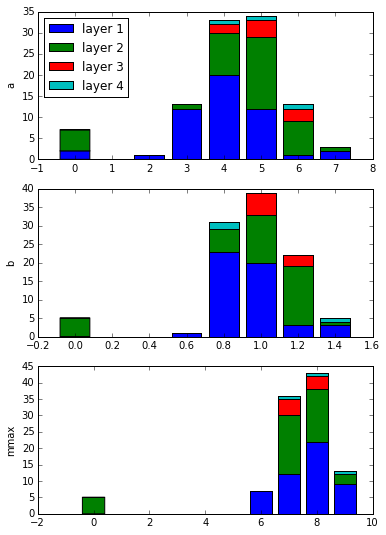

In [76]:
props = ['a','b','mmax']
ranges = [np.arange(-0.5, 8, 1), np.arange(-0.1, 1.7, 0.2), np.arange(-0.5, 10, 1)]
groups = areal_df.groupby('layerid')
fig, axes = plt.subplots(nrows=len(props), ncols=1, figsize=(6, 3*len(props)))
for prop, ax, bins in zip(props, axes, ranges):
    data = [group[prop] for _, group in groups]
    labels = ['layer %d' % id for id, _ in groups]
    ax.hist(data, label=labels, stacked=True, bins=bins)
    ax.set_ylabel(prop)
axes[0].legend(loc='upper left');
plt.savefig("ArealModelFmds.png", dpi=300,
            transparent=True, bbox_inches='tight', pad_inches=0.1)

In [77]:
areal_df[areal_df['tectonic subregion'] == 'no seismicity'].drop(['polygon coordinates'], axis=1)

,zoneid,layerid,tectonic subregion,mmin,a,aspect ratio,b,concerns,dip,mechanism,...,msr,polygon,rake,region,stdb,stdmmax,strike,tectonic zone,zmax,zmin


In [78]:
# read completeness table in anticipation of computing activity rates from smoothed event counts
completeness_df = pd.read_csv('../Data/thingbaijam2011seismogenic/Table1.csv', header=[0,1], index_col=[0,1])
#completeness_df.reset_index(inplace=True)
completeness_df.columns = [' '.join(col).strip() for col in completeness_df.columns.values]
completeness_df.reset_index(inplace=True)
display(completeness_df)
print completeness_df.columns
print completeness_df.index

,zmin,zmax,4 start,4 end,4.5 start,4.5 end,5.5 start,5.5 end
0,0,25,1994,2008,1964,2008,1903,2008
1,25,70,1990,2008,1964,2008,1902,2008
2,70,180,1996,2008,1964,2008,1914,2008
3,180,300,1970,2008,1984,2008,1912,2008


Index([u'zmin', u'zmax', u'4 start', u'4 end', u'4.5 start', u'4.5 end',
       u'5.5 start', u'5.5 end'],
      dtype='object')
Int64Index([0, 1, 2, 3], dtype='int64')


In [79]:
# read smoothed seismicity data
smoothed_df_list = []
for i, mag in enumerate(min_mags):   
    layer_smoothed_df_list = []
    for j, layer in pd.merge(completeness_df, df_layers).iterrows():
        layer_smoothed_df = pd.read_csv(smoothed_data_files[i][j])
        nu_mag = 'nu%s' % str(mag).replace('.','_')

        rename_cols = {nu_mag: 'nu', 'lat':'latitude', 'lon':'longitude'}
        layer_smoothed_df.rename(columns=rename_cols, inplace=True)
        
        layer_smoothed_df['layerid'] = layer['id']
        layer_smoothed_df['mmin model'] = mag
        layer_smoothed_df['mmin'] = mag
        layer_smoothed_df['duration'] = (layer[str(mag) + ' end'] - 
                                         layer[str(mag) + ' start'] + 1)
        layer_smoothed_df['lambda'] = layer_smoothed_df['nu']/layer_smoothed_df['duration']

        layer_smoothed_df_list.append(layer_smoothed_df)
    
    layer_smoothed_df = pd.concat(layer_smoothed_df_list)
    smoothed_df_list.append(layer_smoothed_df)
    
smoothed_df = pd.concat(smoothed_df_list)
smoothed_df = smt.sort_and_reindex(smoothed_df)

display(pd.concat((smoothed_df.head(), smoothed_df.tail())))

,longitude,latitude,layerid,mmin,duration,lambda,mmin model,nu
0,60.0,23.2,2,4.5,45,1.072444e-04,4.5,0.004826
1,60.0,23.4,2,4.5,45,3.808889e-05,4.5,0.001714
2,60.0,23.6,1,5.5,106,2.518868e-05,5.5,0.002670
3,60.0,23.6,2,4.5,45,1.102222e-05,4.5,0.000496
4,60.0,23.6,2,5.5,107,8.411215e-07,5.5,0.000090
97098,100.6,3.6,3,5.5,95,1.176211e-04,5.5,0.011174
97099,100.6,3.8,1,4.5,45,1.604444e-05,4.5,0.000722
97100,100.6,3.8,2,4.5,45,9.576889e-04,4.5,0.043096
97101,100.6,3.8,3,4.5,45,1.925356e-03,4.5,0.086641
97102,100.6,3.8,3,5.5,95,1.645579e-04,5.5,0.015633


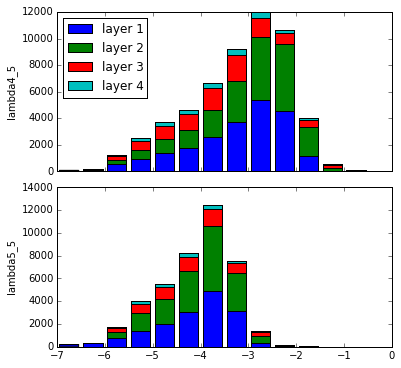

In [80]:
prop = 'lambda'
fig, axes = plt.subplots(nrows=len(min_mags), ncols=1, figsize=(6, 3*len(min_mags)), sharex=True)
fig.subplots_adjust(hspace=0.1)
for min_mag, ax in zip(min_mags, axes):
    groups = smoothed_df[smoothed_df['mmin model'] == min_mag].groupby('layerid')
    data = [np.log10(group[prop]).values for _, group in groups]
    labels = ['layer %d' % id for id, _ in groups]
    ax.hist(data, label=labels, stacked=True, bins=np.arange(-7,0,0.5))
    ax.set_ylabel(('%s%g' % (prop, min_mag)).replace('.','_'))
axes[0].legend(loc='upper left')
plt.savefig("SmoothedModelActivityRates.png", dpi=300,
            transparent=True, bbox_inches='tight', pad_inches=0.1)

In [81]:
# compute all distances
distances = np.full((len(smoothed_df), len(areal_df)), np.inf)
for i, area_series in areal_df.iterrows():
    at_depth = (smoothed_df['layerid'] == area_series['layerid']).values
    mesh = geo.mesh.Mesh(
        smoothed_df.loc[at_depth, 'longitude'].values,
        smoothed_df.loc[at_depth, 'latitude'].values)
    distances[at_depth, i] = area_series['polygon'].distances(mesh)

The truncated Gutenberg-Richter magnitude-frequency distribution in OpenQuake implements
$$\lambda(m \geq M) = 10^{a - b m} = e^{\alpha - \beta m}$$
where, since $\lambda$ is an annual rate, $10^a$ is too. If we ignore events below some threshold $m_{min}$ then the annual rate becomes
$$\lambda(m \geq m_{min}) = e^{\alpha - \beta m_{min}} e^{-\beta (m - m_{min})} = \nu e^{-\beta (m - m_{min})} $$
Thus to compute the $a$ value required by OpenQuake from the activity rate $\nu$ for a given magnitude threshold, we must also take into account the $b$ value for the zone:
$$a = \log_{10}(\nu) + b m_{min}$$


In [83]:
zone_id = '22'
this_model = smoothed_df['mmin model'] == 4.5
this_zone = areal_df['zoneid'] == zone_id
n_points_in_area = (distances == 0).sum(axis=0)
drop_cols = ['tectonic subregion','region', 'tectonic zone',
             'aspect ratio', 'polygon coordinates']
fmd_cols = ['zoneid','layerid','a','b','stdb','mmax','stdmmax','mmin']

print n_points_in_area[areal_df[this_zone].index[0]]
display(areal_df[this_zone][fmd_cols])
print areal_df[this_zone]['b']*areal_df[this_zone]['mmin']
in_zone = (distances[:, areal_df[this_zone].index] == 0)

452


,zoneid,layerid,a,b,stdb,mmax,stdmmax,mmin
16,22,1,3.34,0.73,0.1,8.8,0.2,4.5


16    3.285
dtype: float64


In [94]:
# for each point in the smoothed model, choose the closest areal zone 
# and copy some useful columns over
columns_to_copy = ['zoneid', 'zmax', 'zmin', 'tectonic subregion',
                   'a', 'b', 'stdb', 'mmax', 'stdmmax',
                   'rake', 'dip', 'strike', 'aspect ratio', 'msr']
index_min = distances.argmin(axis=1)
for i, area_series in areal_df.iterrows():
    picked = i == index_min
    for column in columns_to_copy:
        smoothed_df.loc[picked, column] = area_series[column]
    # grab mmax and bvalue from zone above if mmax zero for this zone
    if area_series['mmax'] == 0:
        alternate_zone = str(int(np.floor(float(area_series['zoneid'])/10)))
        print 'For', area_series['zoneid'], 'using MFD from', alternate_zone
        index_alt = np.where(areal_df['zoneid'] == alternate_zone)[0]
        if len(index_alt) > 0:
            smoothed_df.loc[picked, 'mmax'] = areal_df.loc[index_alt[0], 'mmax']
            smoothed_df.loc[picked, 'b'] = areal_df.loc[index_alt[0], 'b']

# computing the a-value for each zone is now a cinch
smoothed_df['a zone'] = smoothed_df['a'].copy()
smoothed_df['a'] = smoothed_df['lambda'] + smoothed_df['b']*smoothed_df['mmin model']

# for each area in the areal model: count the number of points and 
# sum the activity rates in the smoothed model. from the latter estimate
# an equivalent a-value
for mag in min_mags:
    this_model = smoothed_df['mmin model'] == mag
    sum_lambda = np.array([smoothed_df.loc[(distance == 0) & this_model.values, 'lambda'].sum()
          for distance in distances.T])
    areal_df['smoothed N ' +  str(mag)] = (distances[this_model.values, :] == 0).sum(axis=0)
    areal_df['smoothed lambda ' +  str(mag)] = sum_lambda.round(4)
    areal_df['smoothed a ' +  str(mag)] = (np.log10(sum_lambda) + areal_df['b']*mag).round(2)
    areal_df['areal lambda ' +  str(mag)] = (10**(areal_df['a'] - areal_df['b']*mag)).round(4)

For 9031 using MFD from 903
For 9081 using MFD from 908
For 9131 using MFD from 913
For 9151 using MFD from 915
For 9171 using MFD from 917


In [99]:
display_drop = ['zmax', 'zmin', 'aspect ratio', 'msr',
                'rake','dip','strike','stdb','stdmmax']
no_mmax_df = smoothed_df[smoothed_df['mmax'] == 0]
if len(no_mmax_df) > 0:
    print "Leftover points with no assigned mmax"
    display(no_mmax_df.drop(display_drop, axis=1).head())
no_b_df = smoothed_df[smoothed_df['b'] == 0]
if len(no_b_df) > 0:
    print "Leftover points with no assigned b"
    display(no_b_df.drop(display_drop, axis=1).head())
no_zoneid_df = smoothed_df[smoothed_df['zoneid'].isnull()]
if len(no_zoneid_df) > 0:
    print "Leftover points with no assigned zone id"
    display(no_zoneid_df.drop(display_drop, axis=1).head())
if not len(no_mmax_df) and not len(no_b_df) and not len(no_zoneid_df):
    print "SUCCESS: No points with unassigned MFD or zone"

SUCCESS: No points with unassigned MFD or zone


In [100]:
pd.concat((smoothed_df.head(), smoothed_df.tail())).drop(display_drop, axis=1)

,longitude,latitude,layerid,mmin,duration,lambda,mmin model,nu,zoneid,tectonic subregion,a,b,mmax,a zone
0,60.0,23.2,2,4.5,45,1.072444e-04,4.5,0.004826,9031,subduction interface,5.040107,1.12,7.0,0.00
1,60.0,23.4,2,4.5,45,3.808889e-05,4.5,0.001714,9031,subduction interface,5.040038,1.12,7.0,0.00
2,60.0,23.6,1,5.5,106,2.518868e-05,5.5,0.002670,14,subduction interface,3.960025,0.72,8.6,3.12
3,60.0,23.6,2,4.5,45,1.102222e-05,4.5,0.000496,95,subduction interface,4.230011,0.94,7.6,4.35
4,60.0,23.6,2,5.5,107,8.411215e-07,5.5,0.000090,95,subduction interface,5.170001,0.94,7.6,4.35
97098,100.6,3.6,3,5.5,95,1.176211e-04,5.5,0.011174,167,subduction intraslab,5.885118,1.07,8.0,5.41
97099,100.6,3.8,1,4.5,45,1.604444e-05,4.5,0.000722,58,active shallow crust strike-slip reverse,4.275016,0.95,8.4,4.95
97100,100.6,3.8,2,4.5,45,9.576889e-04,4.5,0.043096,138,subduction interface,4.950958,1.10,8.3,5.62
97101,100.6,3.8,3,4.5,45,1.925356e-03,4.5,0.086641,167,subduction intraslab,4.816925,1.07,8.0,5.41
97102,100.6,3.8,3,5.5,95,1.645579e-04,5.5,0.015633,167,subduction intraslab,5.885165,1.07,8.0,5.41


In [101]:
this_lon_lat = (smoothed_df['longitude'] == 98) & (smoothed_df['latitude'] == 3.7)
display(smoothed_df[this_lon_lat].drop(display_drop, axis=1))

,longitude,latitude,layerid,mmin,duration,lambda,mmin model,nu,zoneid,tectonic subregion,a,b,mmax,a zone


In [102]:
areal_display_drop = display_drop + ['polygon','polygon coordinates','tectonic zone','concerns','layerid']
pd.concat((areal_df.head(), areal_df.tail())).drop(areal_display_drop, axis=1)

,zoneid,tectonic subregion,mmin,a,b,mechanism,mmax,region,smoothed N 4.5,smoothed lambda 4.5,smoothed a 4.5,areal lambda 4.5,smoothed N 5.5,smoothed lambda 5.5,smoothed a 5.5,areal lambda 5.5
0,1,subduction interface,4.5,5.20,1.05,dextral,8.0,Pamirs,135,3.0183,5.20,2.9854,135,0.0797,4.68,0.2661
1,2,subduction interface,4.5,4.64,0.93,reverse,8.0,Pamirs,122,2.4047,4.57,2.8510,122,0.1219,4.20,0.3350
2,3,active shallow crust strike-slip reverse,4.5,3.75,0.77,reverse,8.0,Qaidam,78,1.3098,3.58,1.9275,78,0.1012,3.24,0.3273
3,4,subduction interface,4.5,4.34,0.98,dextral,7.4,Kunlun Shan,394,0.9098,4.37,0.8511,293,0.0183,3.65,0.0891
4,5,subduction interface,4.5,4.29,0.91,reverse,7.8,NaN,124,1.6744,4.32,1.5668,124,0.1001,4.01,0.1928
99,9031,subduction interface,4.5,0.00,0.00,undefined,0.0,Murray Ridge,455,0.4213,-0.38,1.0000,415,0.0440,-1.36,1.0000
100,9081,subduction interface,4.5,0.00,0.00,undefined,0.0,Himalayas,311,1.7840,0.25,1.0000,311,0.0548,-1.26,1.0000
101,9131,subduction interface,4.5,0.00,0.00,undefined,0.0,NaN,304,1.0103,0.00,1.0000,290,0.0616,-1.21,1.0000
102,9151,subduction interface,4.5,0.00,0.00,undefined,0.0,NaN,229,0.1956,-0.71,1.0000,186,0.0209,-1.68,1.0000
103,9171,stable shallow crust,4.5,0.00,0.00,undefined,0.0,Bay of Bengal,2170,0.9572,-0.02,1.0000,1533,0.1074,-0.97,1.0000


In [107]:
activity_df = areal_df[[
        'zoneid', 'layerid', 'areal lambda 4.5', 'areal lambda 5.5', 
        'smoothed lambda 4.5', 'smoothed lambda 5.5', 'smoothed N 4.5', 'smoothed N 5.5']]
activity_df = activity_df.rename(
    columns={'areal lambda 4.5': 'areal 4.5', 'smoothed lambda 4.5': 'smoothed 4.5',
             'areal lambda 5.5': 'areal 5.5', 'smoothed lambda 5.5': 'smoothed 5.5',
             'smoothed N 4.5': 'N 4.5', 'smoothed N 5.5': 'N 5.5'})

for layer_id in layer_ids:
    series = pd.Series(activity_df[activity_df['layerid'] == layer_id].sum(axis=0))
    series['layerid'] = layer_id
    series['zoneid'] = 'All'
    activity_df = activity_df.append(series, ignore_index=True)

series = pd.Series(activity_df[activity_df['zoneid'] == 'All'].sum(axis=0))
series['layerid'] = 'All'
series['zoneid'] = 'All'
activity_df = activity_df.append(series, ignore_index=True)
activity_df['ratio 4.5'] = (activity_df['smoothed 4.5']/activity_df['areal 4.5']).round(2)
activity_df['ratio 5.5'] = (activity_df['smoothed 5.5']/activity_df['areal 5.5']).round(2)

picked_zones = [(activity_df['zoneid'] == zone).argmax() for zone in ['21', '22']]
display(pd.concat((activity_df.loc[picked_zones, :], activity_df[activity_df['zoneid'] == 'All'])))
activity_df.to_csv('activity_rates_by_zone_areal_vs_smoothed.csv')

,zoneid,layerid,areal 4.5,areal 5.5,smoothed 4.5,smoothed 5.5,N 4.5,N 5.5,ratio 4.5,ratio 5.5
15,21,1,1.1092,0.1567,2.0420,0.1091,310,310,1.84,0.70
16,22,1,1.1350,0.2113,0.8727,0.0530,226,226,0.77,0.25
104,All,1,79.4757,8.4216,54.2769,3.0869,20659,14937,0.68,0.37
105,All,2,67.5499,10.4452,82.0290,3.7690,19025,15814,1.21,0.36
106,All,3,35.7063,2.9145,39.6688,1.5284,4841,3538,1.11,0.52
107,All,4,11.4753,1.5774,22.8478,1.1899,1191,738,1.99,0.75
108,All,All,194.2072,23.3587,198.8225,9.5742,45716,35027,1.02,0.41


In [108]:
# try computing layers directly
layer_activity_df = pd.DataFrame()
layer_activity_df.index.name = 'layerid'

for layer_id in layer_ids:
    in_areal_layer = areal_df['layerid'] == layer_id
    in_smoothed_layer = smoothed_df['layerid'] == layer_id
    
    layer_series = pd.Series()
    for mag in min_mags:

        this_model = smoothed_df['mmin model'] == mag
        layer_series = layer_series.append(pd.Series({
            'areal ' + str(mag): (10**(areal_df[in_areal_layer]['a'] - 
                                       areal_df[in_areal_layer]['b']*mag)).sum().round(1),
            'smoothed ' + str(mag): smoothed_df[in_smoothed_layer & this_model]['lambda'].sum().round(1), 
            }, name=layer_id))
    layer_activity_df = layer_activity_df.append(layer_series)

layer_activity_df = layer_activity_df.append(pd.Series(layer_activity_df.sum(axis=0), name='Total'))
for mag in min_mags:
    layer_activity_df['ratio ' + str(mag)] = (layer_activity_df['smoothed ' + str(mag)]/
                                              layer_activity_df['areal ' + str(mag)]).round(2)

display(layer_activity_df)

,areal 4.5,areal 5.5,smoothed 4.5,smoothed 5.5,ratio 4.5,ratio 5.5
layerid,,,,,,
1,79.5,8.4,57.4,3.3,0.72,0.39
2,67.5,10.4,85.1,3.9,1.26,0.38
3,35.7,2.9,42.9,1.8,1.20,0.62
4,11.5,1.6,23.9,1.3,2.08,0.81
Total,194.2,23.3,209.3,10.3,1.08,0.44


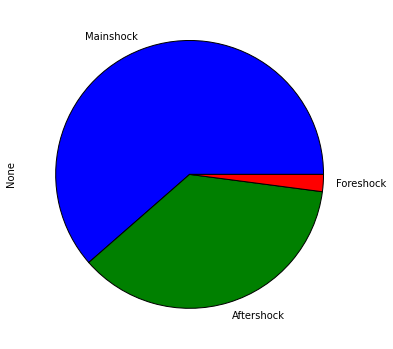

In [109]:
catalogue_df = pd.read_csv('../Catalogue/SACAT1900_2008v2.txt', sep='\t')
catalogue_df['SHOCK_TYPE'].value_counts().plot(kind='pie', figsize=(6, 6));

In [110]:
# assign zones to events
catalogue_df['zoneid'] = -1
for i, area_series in areal_df.iterrows():
    at_depth = ((catalogue_df['DEPTH'] >= area_series['zmin']) & 
                (catalogue_df['DEPTH'] < area_series['zmax']))
    mesh = geo.mesh.Mesh(catalogue_df['LON'].values,
                         catalogue_df['LAT'].values)
    in_area = area_series['polygon'].distances(mesh) == 0
    catalogue_df.loc[at_depth & in_area, 'zoneid'] = area_series['zoneid']

In [111]:
pd.concat((catalogue_df.head(), catalogue_df.tail()))

,YEAR,MONTH,DAY,HH,MM,SS,LAT,LON,DEPTH,DEPTH_ERR,NMAG_TYPE,MAG,MAG_ERR,MAG_MW,MAG_MW_ERR,SOURCE,SHOCK_TYPE,zoneid
0,1900,1,16,-1,-1,-1.00,20.4000,73.0000,-1.0,-1,MW,3.3,-1.0,3.2,0.46,JS2004a,Mainshock,-1
1,1900,2,7,-1,-1,-1.00,10.8000,76.8000,70.0,-1,MW,5.7,-1.0,5.7,0.30,ASC2009a,Mainshock,-1
2,1901,4,27,-1,-1,-1.00,12.0000,75.0000,-1.0,-1,MW,4.7,-1.0,4.6,0.46,JS2004a,Mainshock,-1
3,1901,10,17,5,57,-1.00,31.0000,68.4000,-1.0,-1,MW,6.2,-1.0,6.2,-1.00,AM2000a,Mainshock,-1
4,1901,11,18,4,-1,-1.00,32.0000,77.0000,-1.0,-1,MW,6.3,-1.0,6.3,-1.00,AM2000a,Mainshock,-1
50327,2008,12,31,15,32,49.18,37.1648,71.9958,122.3,63,mb,3.5,0.1,3.7,0.29,ISC,Mainshock,153
50328,2008,12,31,15,46,15.95,31.8322,79.7829,0.0,-1,mb,3.8,0.1,4.0,0.29,ISC,Foreshock,904
50329,2008,12,31,16,12,13.92,31.7710,79.7206,0.0,-1,MS,3.9,-1.0,4.6,0.19,ISC,Mainshock,904
50330,2008,12,31,17,12,50.71,37.2136,70.3485,0.0,-1,mb,3.8,-1.0,4.0,0.41,ISC,Mainshock,9
50331,2008,12,31,20,48,35.71,36.2467,70.8264,197.0,44,mb,3.3,0.1,3.5,0.28,ISC,Mainshock,169


In [115]:
# for each minimum magnitude and layer work out the activity rates
catalogue_activity_df = pd.DataFrame()
for _, layer in pd.merge(completeness_df, df_layers).iterrows():
    layer_results = pd.Series()
    for mag in reversed(min_mags):
        above_thresh = catalogue_df['MAG_MW'] >= mag
        start = layer[str(mag) + ' start']
        end = layer[str(mag) + ' end']
        at_depth = ((catalogue_df['DEPTH'] >= layer['zmin']) & 
                    (catalogue_df['DEPTH'] < layer['zmax']))
        in_years = ((catalogue_df['YEAR'] >= start) & 
                    (catalogue_df['YEAR'] <= end))
        in_a_zone = catalogue_df['zoneid'] != -1
        is_mainshock = catalogue_df['SHOCK_TYPE'] == 'Mainshock'
        subcat_df = catalogue_df[above_thresh & at_depth & in_years & in_a_zone & is_mainshock]
        layer_results = layer_results.append(pd.Series({
                'cat ' + str(mag): len(subcat_df)/(end - start + 1),
            }, name=layer['id']))
    catalogue_activity_df = catalogue_activity_df.append(layer_results)
catalogue_activity_df = catalogue_activity_df.append(pd.Series(catalogue_activity_df.sum(axis=0), name='Total'))
display(layer_activity_df.join(catalogue_activity_df))
summary_tex = 'activity_rates_by_layer_areal_vs_smoothed_vs_catalogue.tex'
layer_activity_df.join(catalogue_activity_df).to_latex(summary_tex, index=False)

,areal 4.5,areal 5.5,smoothed 4.5,smoothed 5.5,ratio 4.5,ratio 5.5,cat 4.5,cat 5.5
layerid,,,,,,,,
1,79.5,8.4,57.4,3.3,0.72,0.39,54,3
2,67.5,10.4,85.1,3.9,1.26,0.38,78,3
3,35.7,2.9,42.9,1.8,1.20,0.62,39,1
4,11.5,1.6,23.9,1.3,2.08,0.81,10,1
Total,194.2,23.3,209.3,10.3,1.08,0.44,181,8


In [116]:
min_mag = 5.5
layer_id = 1
model_layer = (smoothed_df['mmin model'] == min_mag) & \
    (smoothed_df['layerid'] == layer_id)
subset_df = smoothed_df[model_layer].copy()

lon_list = sorted(list(set(subset_df['longitude'])))
lat_list = sorted(list(set(subset_df['latitude'])))

lon_min, lon_max = [min(lon_list), max(lon_list)]
lat_min, lat_max = [min(lat_list), max(lat_list)]
lon_res = np.diff(lon_list).min().round(2)
lat_res = np.diff(lat_list).min().round(2)

lon_list = np.arange(lon_min, lon_max + lon_res, lon_res).round(2)
lat_list = np.arange(lat_min, lat_max + lat_res, lat_res).round(2)
lat_grid, lon_grid = np.meshgrid(lat_list, lon_list)

# assign known values
num_columns = ['a', 'b', 'nu']
txt_columns = ['tectonic subregion']
data = {}
for column in num_columns:
    data[column] = np.full_like(lon_grid, np.nan)
for column in txt_columns:
    data[column] = np.full_like(lon_grid, '', dtype='object')

for _, point_series in subset_df.iterrows():
    i = int(round((point_series['longitude'] - lon_min)/lon_res))
    j = int(round((point_series['latitude'] - lat_min)/lat_res))
    for column in num_columns:
        data[column][i, j] = point_series[column]
    for column in txt_columns:
        data[column][i, j] = point_series[column]

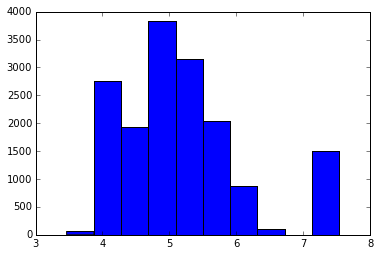

In [117]:
param = 'a'
if param in ['nu']:
    log_scale = True
else:
    log_scale = False
limits = (np.nanmin(data[param]), np.nanmax(data[param]))
plt.hist(data[param].ravel(), range=limits, log=log_scale);
plt.savefig("SmoothedEquivalentMap_%s_mmin%g_layer%d.png" % (param, min_mag, layer_id), dpi=300,
            transparent=True, bbox_inches='tight', pad_inches=0.1)

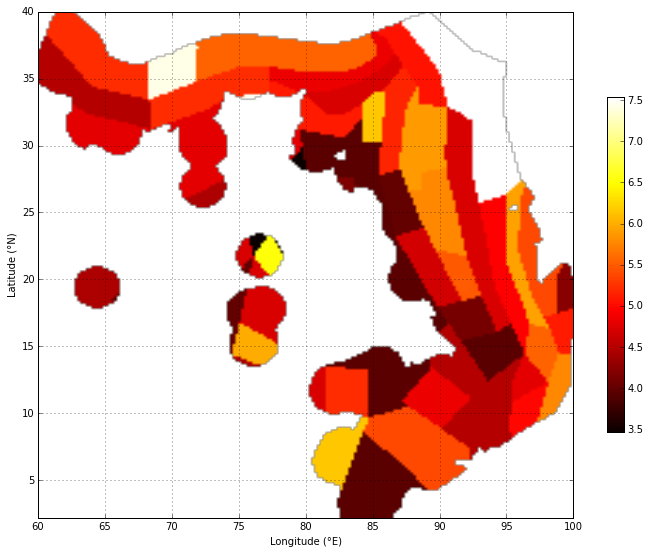

In [118]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca()
if log_scale:
    plt.imshow(data[param], cmap='hot', origin='lower', aspect='equal', 
               extent=(lon_min, lon_max, lat_min, lat_max), 
               norm=LogNorm(vmin=limits[0], vmax=limits[1]))
else:
    plt.imshow(data[param], cmap='hot', origin='lower', aspect='equal', 
               extent=(lon_min, lon_max, lat_min, lat_max))

plt.colorbar(shrink=0.5)
ax.set_xlabel(u'Longitude (°E)')
ax.set_ylabel(u'Latitude (°N)')
ax.grid()
plt.savefig("SmoothedEquivalentMap_%s_mmin%g_layer%d.png" % (param, min_mag, layer_id), dpi=300,
            transparent=True, bbox_inches='tight', pad_inches=0.1)

In [126]:
# write areal model data to TSV file ==> when this completes, logic tree can be generated
areal_output_df = smt.sort_and_reindex(smt.add_name_id(
    smt.twin_source_by_magnitude(areal_df)).drop(['polygon'], axis=1))
areal_output_df.to_csv(areal_source_model_file + '.tsv', sep='\t')

In [119]:
# write each layer of areal source model to KML with added binwise rates
areal_kml_df = smt.add_name_id(smt.add_binwise_rates(areal_df).drop(['polygon'], axis=1))
for layer_id in layer_ids:
    this_layer = areal_kml_df['layerid'] == layer_id
    temp_df = areal_kml_df.drop(['layerid'], axis=1)
    smt.source_df_to_kml(temp_df.loc[this_layer, :], 
        '%s layer %d' % (areal_source_model_file, layer_id))

In [122]:
# write areal source model with megathrust sources twinned to NRML
areal_source_list = smt.source_df_to_list(
    smt.add_name_id(smt.twin_source_by_magnitude(areal_df)))
areal_source_model = src.source_model.mtkSourceModel(
    identifier='1', 
    name=os.path.split(model_path)[1] + ' areal', 
    sources=areal_source_list)
areal_source_model.serialise_to_nrml(areal_source_model_file + '.xml')

In [120]:
# thin smoothed DataFrame so that resulting KML files are small enough to be read into QGIS
smoothed_kml_df = smoothed_df.copy()
drop_columns = ['aspect ratio','rake','dip','strike','msr','stdb','stdmmax']
smoothed_kml_df.drop(drop_columns, axis=1, inplace=True)
res_deg = 0.2
this_lon_lat = ((((smoothed_kml_df['latitude'] % res_deg).round(2) % res_deg) == 0) &
                (((smoothed_kml_df['longitude'] % res_deg).round(2) % res_deg) == 0))
smoothed_kml_df = smoothed_kml_df[this_lon_lat]

# write each layer to KML with added binwise rates
for min_mag in reversed(min_mags):
    for layer_id in reversed(layer_ids):
        temp_df = smt.add_name_id(smoothed_kml_df)
        this_model_layer = ((temp_df['mmin model'] == min_mag) &
                   (temp_df['layerid'] == layer_id))
        temp_df.drop(['zmax', 'zmin', 'mmin model', 'layerid'], axis=1, inplace=True)
        smt.source_df_to_kml(temp_df.loc[this_model_layer, :], 
            '%s mmin %g layer %d' % (smoothed_source_data_file, min_mag, layer_id))

In [123]:
# write point source models with megathrust sources twinned to NRML
for min_mag in min_mags:
    this_model = smoothed_df['mmin'] == min_mag 
    smoothed_source_list = smt.source_df_to_list(
        smt.add_name_id(smt.twin_source_by_magnitude(smoothed_df.loc[this_model, :])))
    smoothed_source_model = src.source_model.mtkSourceModel(
        identifier='1', 
        name=os.path.split(model_path)[1] + 'smoothed m_min=%g' % min_mag, 
        sources=smoothed_source_list)
    file_name = smoothed_source_data_file + '_mmin%g.xml' % min_mag 
    smoothed_source_model.serialise_to_nrml(file_name)

In [124]:
class PseudoCatalogue:
    """
    ugly hack for plotting source mechanisms: 
    construct pseudo-cataloge from pandas.DataFrame
    """
    def __init__(self, source_model, select_depth='all'):
        data = []
        oq_sources = source_model.convert_to_oqhazardlib(tom.PoissonTOM(1.0))
        for source in oq_sources:
            
            longitude = np.mean(source.polygon.lons)
            latitude = np.mean(source.polygon.lats)
            strike = source.nodal_plane_distribution.data[0][1].strike
            dip = source.nodal_plane_distribution.data[0][1].dip
            rake = source.nodal_plane_distribution.data[0][1].rake
            magnitude = source.get_min_max_mag()[1]*2.5
            depth = source.hypocenter_distribution.data[0][1]
            name = source.id
            
            if select_depth == 'all' or depth == select_depth:
                data.append({'longitude': longitude, 'latitude': latitude,
                             'strike1': strike, 'dip1': dip, 'rake1': rake,
                             'magnitude': magnitude, 'depth': depth, 'id': name})
        self.data = pd.DataFrame(data)

    def get_number_tensors(self):
        return len(self.data.magnitude)

catalogue = PseudoCatalogue(areal_source_model)

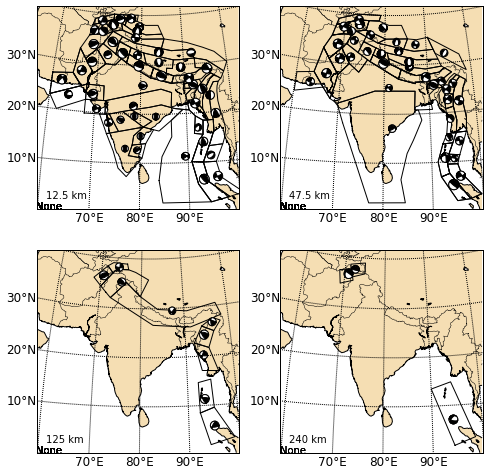

In [125]:
map_config = {"min_lon": 60, "max_lon": 105, 
              "min_lat": 0,  "max_lat": 40, "resolution": "l",
              "parallel_meridian_spacing": 10}
parser = nrmlSourceModelParser(areal_source_model_file + '.xml')

fig, axes = plt.subplots(2, 2, figsize=(8,8), sharex=True, sharey=True)

for depth, ax in zip(sorted(list(set(catalogue.data['depth']))), axes.ravel()):
    fig.sca(ax)
    tb.annotate('%g km' % depth, 'lower left')
    basemap = HMTKBaseMap(map_config, None)

    source_model_read = parser.read_file('Areal Source Model')
    selected_sources = [source for source in source_model_read.sources 
                    if source.hypo_depth_dist.data[0][1] == depth]
    source_model_read.sources = selected_sources    
    selected_catalogue = PseudoCatalogue(source_model_read)

    basemap.add_source_model(source_model_read, overlay=True) 
    basemap.add_focal_mechanism(selected_catalogue, magnitude=False)
    for _, item in selected_catalogue.data.iterrows():
        plt.annotate(s=item.id, xy=(item.longitude, item.latitude))
        
plt.savefig("ArealModelFocalMechanisms.pdf", transparent=True, bbox_inches='tight', pad_inches=0.1)